## 1.1 Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


## 1.2 Loading data


The **CIFAR10** dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Convert images to float32 and normalize to [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Display dataset shapes
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

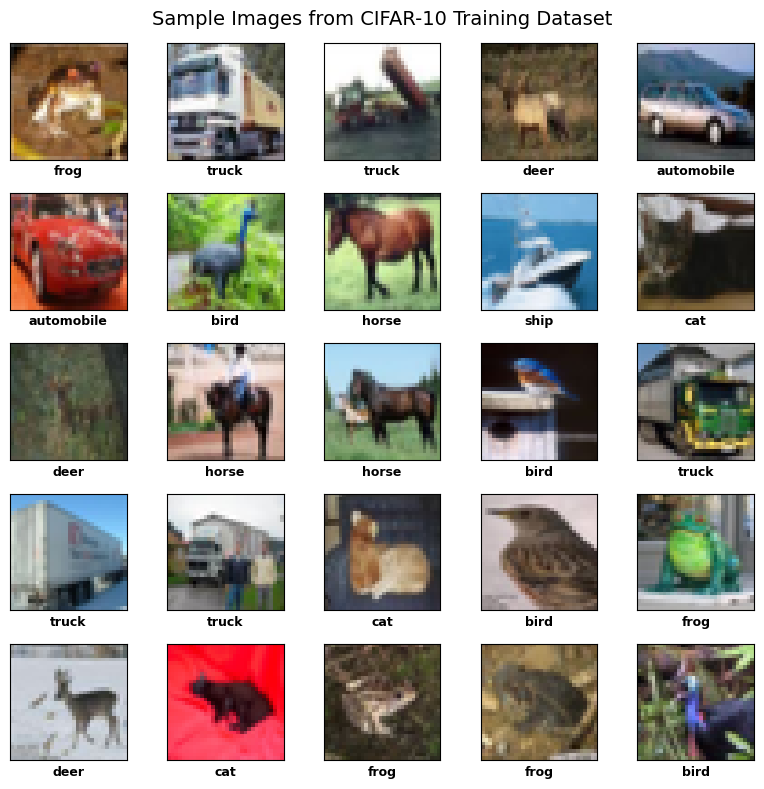

In [4]:
# Class names for CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(
        class_names[int(train_labels[i])],
        fontsize=9,
        fontweight="bold"
    )

plt.suptitle("Sample Images from CIFAR-10 Training Dataset", fontsize=14)
plt.tight_layout()
plt.show()

## 1.3 Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) and [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument **input_shape** to our first layer.


In [5]:
# Create the convolutional base
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(32, 32, 3)))

# Block 1
model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Block 2
model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Block 3
model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.BatchNormalization())

2025-12-24 20:56:45.154919: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-24 20:56:45.155018: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-24 20:56:45.155033: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-24 20:56:45.155497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-24 20:56:45.155899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Now, let's display the architecture of our model.

In [6]:
# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,960 (222.50 KB)

 Trainable params: 56,640 (221.25 KB)

 Non-trainable params: 320 (1.25 KB)

Above, we can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64).

## 1.4 Adding Dense Layers on the top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more **Dense layers** to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [7]:
# Flatten the convolutional output
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))  # Helps prevent overfitting

# Output layer (logits)
model.add(layers.Dense(10))

Here's the complete architecture of our model.

In [8]:
# Display the complete model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,666 (2.22 MB)

 Trainable params: 582,346 (2.22 MB)

 Non-trainable params: 320 (1.25 KB)

So our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

## 1.5 Compile and train the model

In [9]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Callbacks for better training control
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_images,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/20


2025-12-24 20:59:36.648802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.2884 - loss: 5.7611 - val_accuracy: 0.5472 - val_loss: 1.3283
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5303 - loss: 1.4017 - val_accuracy: 0.6111 - val_loss: 1.1011
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6175 - loss: 1.1008 - val_accuracy: 0.6302 - val_loss: 1.0914
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6553 - loss: 1.0109 - val_accuracy: 0.6131 - val_loss: 1.2345
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6780 - loss: 0.9659 - val_accuracy: 0.6467 - val_loss: 1.1502
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6974 - loss: 0.9324 - val_accuracy: 0.6689 - val_loss: 1.1401


## 1.6 Evaluate the model

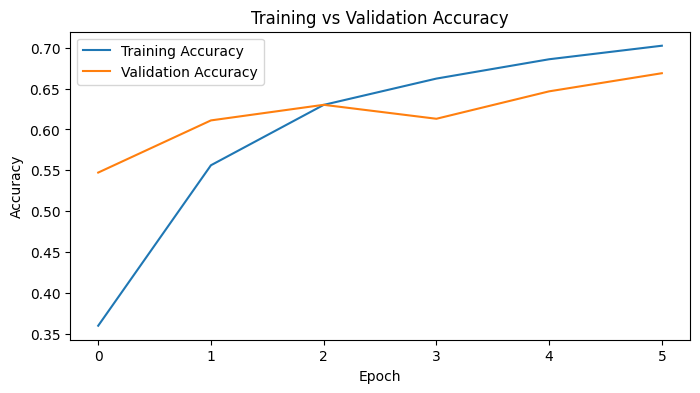

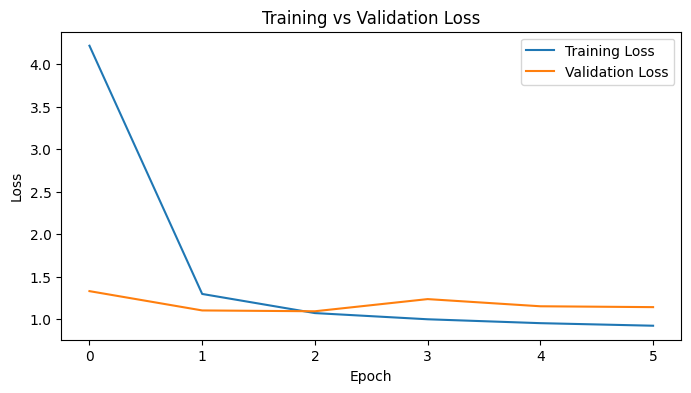

313/313 - 2s - 6ms/step - accuracy: 0.6302 - loss: 1.0914
Test Accuracy: 0.6302


In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

In [11]:
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 63.02%


This simple CNN has achieved a test accuracy of over 60%, which is not bad.

In [12]:
model.save("cifar10_cnn.keras")
print("Model saved successfully!")

Model saved successfully!
